In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [ ]:
train_dir = "/content/drive/MyDrive/Sem6/AI_ML/week_5/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/Sem6/AI_ML/week_5/FruitinAmazon/test"

In [ ]:
# Define dataset path
# Get class names (subdirectories)
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


Number of classes: 6
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


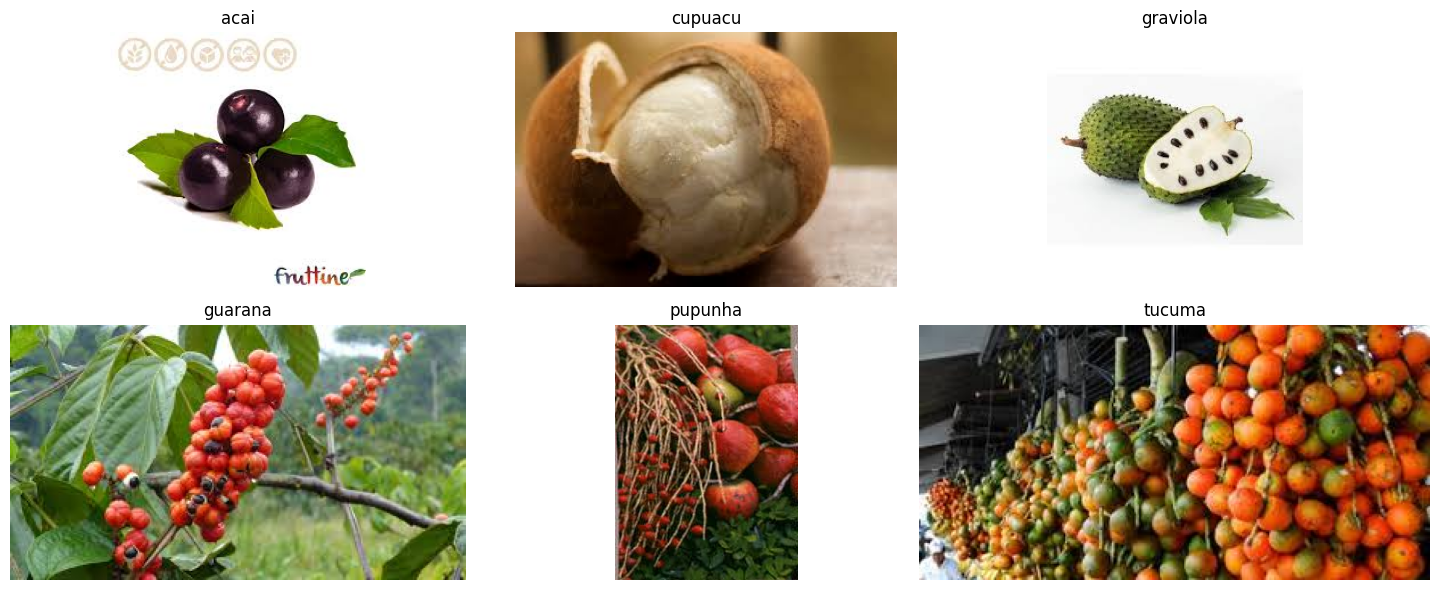

In [ ]:

num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Select one random image from each class
images = []
for class_dir in class_names:
    class_path = os.path.join(train_dir, class_dir)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(class_path, random_image)
        images.append(image_path)

columns = (num_classes + 1) // 2
fig, axes = plt.subplots(2, columns, figsize=(15, 6))
axes = axes.flatten()

# Plot each image
for i, image_path in enumerate(images):
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

# Hide any unused axes if num_classes is odd
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
from PIL import Image, UnidentifiedImageError
corrupted_images = [] # List to store corrupted images path
# Loop through each class folder and check for corrupted images
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path): # Ensure it’s a valid directory
    images = os.listdir(class_path)
    for img_name in images:
      img_path = os.path.join(class_path, img_name)
      try:
        with Image.open(img_path) as img:
          img.verify() # Verify image integrity
      except (IOError, UnidentifiedImageError):
        corrupted_images.append(img_path)

# Print results
if corrupted_images:
  print("\nCorrupted Images Found:")
  for img in corrupted_images:
    print(img)
else:
  print("\nNo corrupted images found.")


No corrupted images found.


In [ ]:
# Dictionary to store class counts
class_counts = {}
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images) # Count images in each class
# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}")
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


In [ ]:
import random
selected_images = [] # Store image paths
selected_labels = [] # Store corresponding class names
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png','.jpg', '.jpeg'))]
    if images: # Ensure the class folder is not empty
      selected_img = os.path.join(class_path, random.choice(images))
      selected_images.append(selected_img)
      selected_labels.append(class_name)

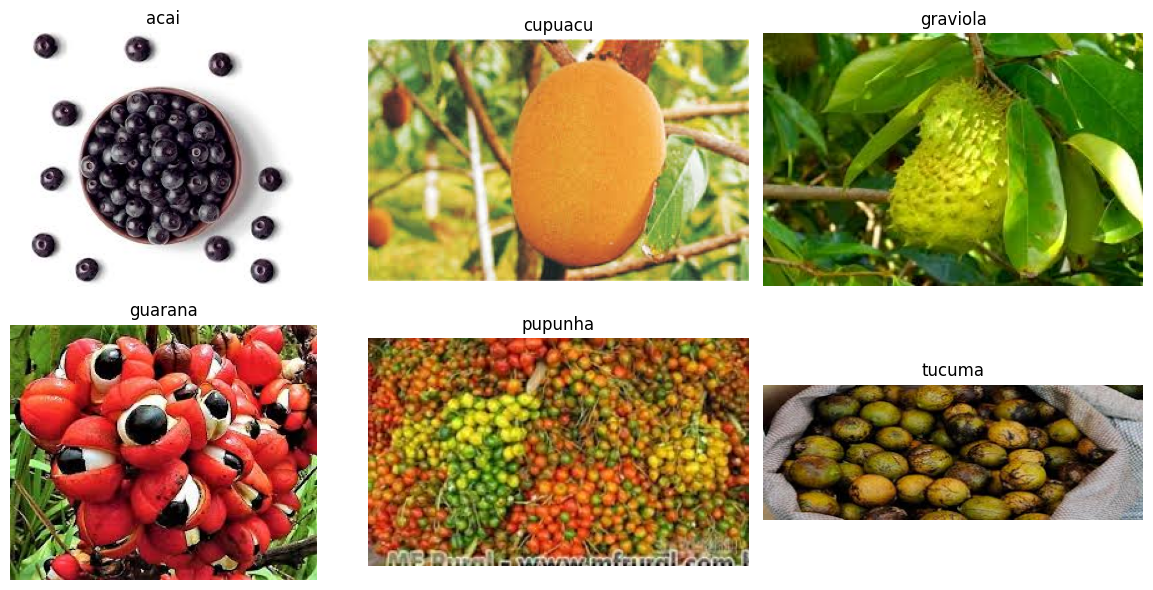

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Determine grid size
num_classes = len(selected_images)
cols = (num_classes + 1) // 2 # Determine columns
rows = 2 # Fixed rows for layout
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
  if i < num_classes:
    img = mpimg.imread(selected_images[i])
    ax.imshow(img)
    ax.set_title(selected_labels[i])
    ax.axis("off")
  else:
    ax.axis("off") # Hide empty subplots
plt.tight_layout()
plt.show()

In [ ]:
# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 128


# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Verify class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")




Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    # Convolutional Block 1
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 2
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 3
    x = layers.Conv2D(128, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Block 4
    x = layers.Conv2D(256, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten
    x = layers.Flatten()(x)

    # Dense Layers
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)

    x = layers.Dense(64)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.1)(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

# Create the model
model = make_model(input_shape=(224, 224, 3), num_classes=len(class_names))
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,257,670 (100.17 MB)

 Trainable params: 26,254,790 (100.15 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('best_model_task1.h5', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Train
history = model.fit(
    train_ds,
    epochs=50,
    batch_size = batch_size,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2111 - loss: 2.3117

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.2111 - loss: 2.3117 - val_accuracy: 0.2000 - val_loss: 1.8243
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3444 - loss: 1.5580 - val_accuracy: 0.1667 - val_loss: 1.8967
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step - accuracy: 0.5778 - loss: 1.0599 - val_accuracy: 0.1667 - val_loss: 1.9349
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step - accuracy: 0.7000 - loss: 0.8527 - val_accuracy: 0.1667 - val_loss: 1.9449
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7889 - loss: 0.8085

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7889 - loss: 0.8085 - val_accuracy: 0.3000 - val_loss: 1.9183
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8667 - loss: 0.6563 - val_accuracy: 0.3000 - val_loss: 1.8939
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9000 - loss: 0.5636 - val_accuracy: 0.2667 - val_loss: 1.8771
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9000 - loss: 0.5306 - val_accuracy: 0.2333 - val_loss: 1.8528
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step - accuracy: 0.9222 - loss: 0.4397 - val_accuracy: 0.2333 - val_loss: 1.8338
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step - accuracy: 0.9444 - loss: 0.4074 - val_accuracy: 0.2667 - val_loss: 1.8043
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9444 - loss: 0.3869 - val_accuracy: 0.2333 - val_loss: 1.7844
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9778 - loss: 0.2912 - val_accuracy: 0.2000 - val_loss: 1.7924
Epoch 13/50
1/1 ━━

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2333 - loss: 1.7844
Test accuracy: 0.2333
Test loss: 1.7844


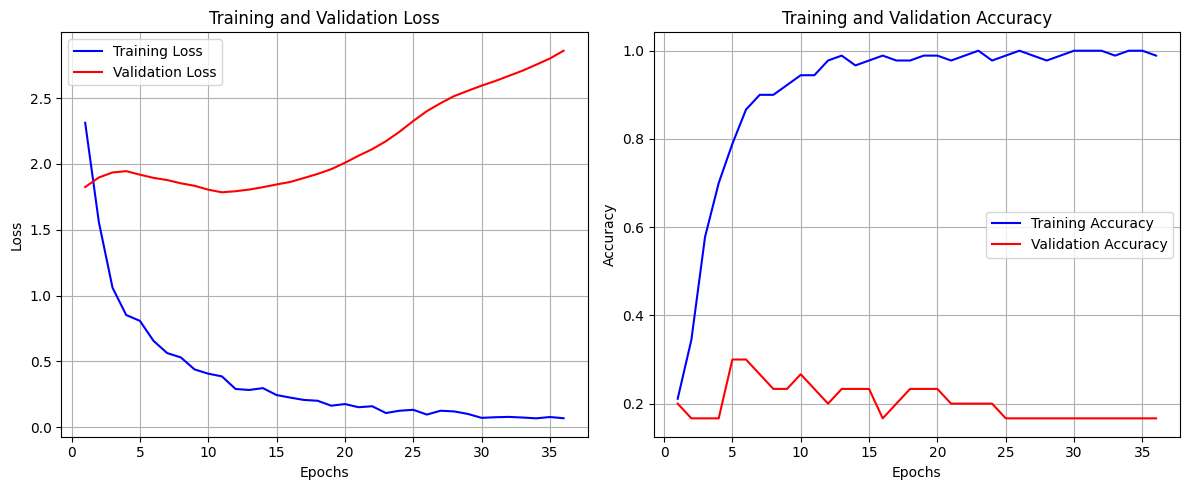

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:
model.save('AshimNepal_w6_task1.h5')
print("Model saved as 'AshimNepal_w5.h5'")

Model saved as 'AshimNepal_w5.h5'


In [ ]:

loaded_model = tf.keras.models.load_model('AshimNepal_w6_task1.h5')
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")
print(f"Loaded model test loss: {loaded_test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1667 - loss: 1.7925
Loaded model test accuracy: 0.1667
Loaded model test loss: 1.7925


In [ ]:
loaded_model = keras.models.load_model('AshimNepal_w6_task1.h5')
print("Model loaded for predictions")

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)  # Shape: (30, 128, 128, 3)
test_labels_onehot = np.concatenate(all_labels, axis=0)  # Shape: (30, 6)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)


print(f"Class names: {class_names}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Model loaded for predictions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       0.00      0.00      0.00         5
     cupuacu       0.16      0.80      0.27         5
    graviola       0.00      0.00      0.00         5
     guarana       0.00      0.00      0.00         5
     pupunha       0.50      0.20      0.29         5
      tucuma       0.00      0.00      0.00         5

    accuracy                           0.17        30
   macro avg       0.11      0.17      0.09        30
weighted avg       0.11      0.17      0.09        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Task 2

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

In [ ]:
model_vgg = keras.Model(inputs=base_model.input, outputs=outputs)

In [ ]:
model_vgg.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train
history_vgg = model_vgg.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    callbacks=[ModelCheckpoint('best_model_task2.h5', monitor='val_accuracy', save_best_only=True),
               EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)]
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.1993 - loss: 5.6103

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2032 - loss: 5.8488 - val_accuracy: 0.3667 - val_loss: 8.2521
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - accuracy: 0.5222 - loss: 5.0671 - val_accuracy: 0.3000 - val_loss: 6.4703
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6547 - loss: 2.2589

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step - accuracy: 0.6698 - loss: 2.1585 - val_accuracy: 0.6667 - val_loss: 2.5292
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 482ms/step - accuracy: 0.9652 - loss: 0.2441 - val_accuracy: 0.5333 - val_loss: 4.6592
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step - accuracy: 0.8716 - loss: 0.8405 - val_accuracy: 0.5333 - val_loss: 5.1558
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 471ms/step - accuracy: 0.8590 - loss: 0.6631 - val_accuracy: 0.6000 - val_loss: 3.6410
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 0.0098

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step - accuracy: 1.0000 - loss: 0.0111 - val_accuracy: 0.7333 - val_loss: 2.7100
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 0.0042

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.7667 - val_loss: 2.4188
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 0.7667 - val_loss: 2.2229
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.7333 - val_loss: 2.1285
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 469ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.7000 - val_loss: 2.1324
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.6667 - val_loss: 2.1790
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 0.6333 - val_loss: 2.2317
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 0.6667 - val_loss: 2.2638
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.6667 - val_loss: 2.26

In [ ]:
# Evaluate
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(test_ds)
print(f"Test accuracy for VGG16: {test_acc_vgg:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.7000 - loss: 2.1013
Test accuracy for VGG16: 0.7000


momentum, rms, adam

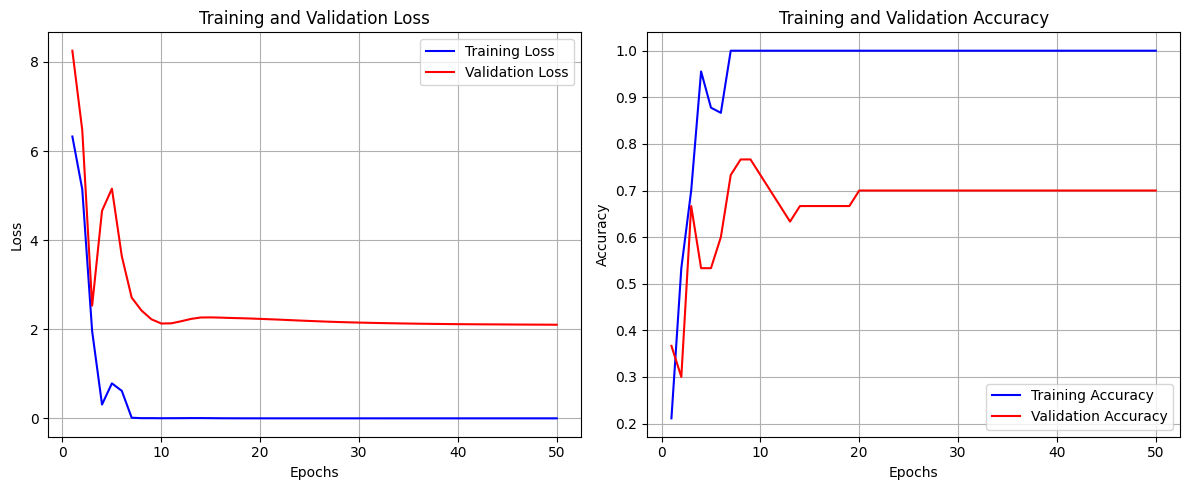

In [ ]:
history_dict = history_vgg.history
epochs = range(1, len(history_dict['loss']) + 1)
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Create subplots: 1 row, 2 columns
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [ ]:


predictions_vgg = model_vgg.predict(test_ds)
y_pred_vgg = np.argmax(predictions_vgg, axis=1)

# Classification Report
print("Classification Report for Task 2 (VGG16):")
print(classification_report(true_labels, y_pred_vgg, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
Classification Report for Task 2 (VGG16):
              precision    recall  f1-score   support

        acai       0.57      0.80      0.67         5
     cupuacu       1.00      0.40      0.57         5
    graviola       0.83      1.00      0.91         5
     guarana       1.00      0.80      0.89         5
     pupunha       0.75      0.60      0.67         5
      tucuma       0.43      0.60      0.50         5

    accuracy                           0.70        30
   macro avg       0.76      0.70      0.70        30
weighted avg       0.76      0.70      0.70        30

